**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

**Import necessary libraries**

In [2]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from gensim.models import Word2Vec

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['IMDB Dataset.csv']


**Prepare data**

In [3]:
#importing the training data
imdb_data=pd.read_csv('../input/IMDB Dataset.csv')

print(imdb_data.shape)
imdb_data.head(10)

#Summary of the dataset
imdb_data.describe()

#sentiment count
imdb_data['sentiment'].value_counts()

(50000, 2)


positive    25000
negative    25000
Name: sentiment, dtype: int64

**Spliting the training dataset**

In [4]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000] #40000
train_sentiments=imdb_data.sentiment[:40000] #40000
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]

print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


**Define method**

In [5]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

**Text normalization: Removing html strips and noise text -> Removing special characters -> Text stemming -> Removing stopwords**

In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
#set stopwords to english
stop=set(stopwords.words('english'))

imdb_data['review']=imdb_data['review'].apply(denoise_text)
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

**Normalized train and test reviews**

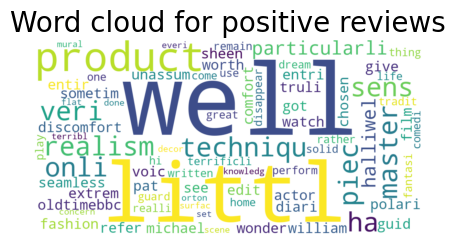

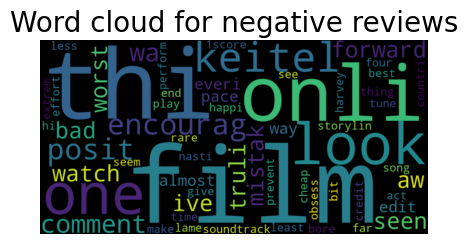

In [7]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
# norm_train_reviews[0]

#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
# norm_test_reviews[45005]

#word cloud for positive review words
plt.figure(figsize = (5,5))
positive_text=norm_train_reviews[1]
WC=WordCloud(max_words = 2000, width=1200, height=600,background_color="white")
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

#Word cloud for negative review words
plt.figure(figsize=(5,5))
negative_text=norm_train_reviews[8]
WC=WordCloud(max_words = 2000, width=1200, height=600,background_color="black")
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

**Bags of words model**

It is used to convert text documents to numerical vectors or bag of words.

In [12]:
#Count vectorizer for bag of words
cv=CountVectorizer(ngram_range=(1, 3), binary=False)
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6983231)
BOW_cv_test: (10000, 6983231)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [8]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 551822)
Tfidf_test: (10000, 551822)


**Word2vec model**

It is used to convert text documents to  vec.

In [9]:
# This function converts a text to a sequence of words.
def review_wordlist(review):
    # Converting to lower case and splitting
    words = review.lower().split()   
    words = [w for w in words]
    return(words)

# word2vec expects a list of lists.
# Using punkt tokenizer for better splitting of a paragraph into sentences.
import nltk.data
w2v_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# This function splits a review into sentences -word2vec need 2D
def review_sentences(review, w2v_tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer
    raw_sentences = w2v_tokenizer.tokenize(review.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence))

    # This returns the list of lists
    return sentences

w2v_train_sentences = []
w2v_test_sentences = []
for review in norm_train_reviews:
    w2v_train_sentences += review_sentences(review, w2v_tokenizer)
for review in norm_test_reviews:
    w2v_test_sentences += review_sentences(review, w2v_tokenizer)
    
num_features = 300
#transformed train reviews
w2v_train_reviews = Word2Vec(w2v_train_sentences, vector_size = num_features, workers = 4, min_count = 20, window = 10)
#transformed test reviews
w2v_test_reviews = Word2Vec(w2v_test_sentences, vector_size = num_features, workers = 4, min_count = 20, window = 10)
print('W2V_train:',w2v_train_reviews.wv.vectors.shape)
print('W2V_test:',w2v_test_reviews.wv.vectors.shape)

W2V_train: (12914, 300)
W2V_test: (5653, 300)


In [10]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index_to_key)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

# Calculating average feature vactors for test set     
trainDataVecs = getAvgFeatureVecs(w2v_train_sentences, w2v_test_reviews, num_features)
testDataVecs = getAvgFeatureVecs(w2v_test_sentences, w2v_test_reviews, num_features)

In [13]:
# Few tests: This will print the odd word among them 
print(w2v_test_reviews.wv.doesnt_match("man woman dog child kitchen".split()))
print(w2v_test_reviews.wv.doesnt_match("france england germany berlin".split()))
print(w2v_test_reviews.wv.most_similar("man"))
# print(w2v_test_reviews.wv.syn0.shape)

kitchen
berlin
[('woman', 0.8942381143569946), ('affair', 0.8101472854614258), ('blind', 0.7908592224121094), ('husband', 0.7887318730354309), ('mother', 0.782196044921875), ('child', 0.7803328037261963), ('marri', 0.7796478271484375), ('wife', 0.7746922373771667), ('sister', 0.7725329995155334), ('father', 0.7666674852371216)]


**Labeling the sentiment text**

**Split the sentiment data**

In [14]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
# print(train_sentiments)
# print(test_sentiments)

(50000, 1)


**define plot method**


In [22]:
def report(bow_predict,tfidf_predict,w2v_predict):
    #Classification report
    bow_report=classification_report(test_sentiments,bow_predict,target_names=['Positive','Negative'])
    print(bow_report)
    tfidf_report=classification_report(test_sentiments,tfidf_predict,target_names=['Positive','Negative'])
    print(tfidf_report)
    w2v_report=classification_report(test_sentiments,w2v_predict,target_names=['Positive','Negative'])
    print(w2v_report)

    #confusion matrix
    cm_bow=confusion_matrix(test_sentiments,bow_predict,labels=[1,0])
    print(cm_bow)
    cm_tfidf=confusion_matrix(test_sentiments,tfidf_predict,labels=[1,0])
    print(cm_tfidf)
    cm_w2v=confusion_matrix(test_sentiments,w2v_predict,labels=[1,0])
    print(cm_w2v)
def plot_roc(bow_predict,tfidf_predict,w2v_predict,bow,tfidf,w2v):    
    #1） F1,P,R
    P1=precision_score(test_sentiments,bow_predict)
    R1=recall_score(test_sentiments,bow_predict)
    F1_1=f1_score(test_sentiments,bow_predict)

    P2=precision_score(test_sentiments,tfidf_predict)
    R2=recall_score(test_sentiments,tfidf_predict)
    F1_2=f1_score(test_sentiments,tfidf_predict)

    P3=precision_score(test_sentiments,w2v_predict)
    R3=recall_score(test_sentiments,w2v_predict)
    F1_3=f1_score(test_sentiments,w2v_predict)

    #2） P-R曲线,ROC曲线
    bow_pre_score=bow.predict_proba(cv_test_reviews)
    bow_precision,bow_recall,_=precision_recall_curve(test_sentiments,bow_pre_score[:,1])
    bow_fpr,bow_tpr,bow_=roc_curve(test_sentiments,bow_pre_score[:,1])

    tfidf_pre_score=tfidf.predict_proba(tv_test_reviews)
    tfidf_precision,tfidf_recall,_=precision_recall_curve(test_sentiments,tfidf_pre_score[:,1])
    tfidf_fpr,tfidf_tpr,tfidf_=roc_curve(test_sentiments,tfidf_pre_score[:,1])

    w2v_pre_score=w2v.predict_proba(testDataVecs)
    w2v_precision,w2v_recall,w2v_=precision_recall_curve(test_sentiments,w2v_pre_score[:,1])
    w2v_fpr,w2v_tpr,w2v_=roc_curve(test_sentiments,w2v_pre_score[:,1])

    #1) P-R曲线 
    plt.plot(bow_recall,bow_precision,label='bow-PR',color='red')
    plt.plot(tfidf_recall,tfidf_precision,label='tfidf-PR',color='blue')
    plt.plot(w2v_recall,w2v_precision,label='w2v-PR',color='green')
    plt.xlabel('Recall Rate')
    plt.ylabel('Persion Rate')
    plt.legend()
    plt.show()

    #2）ROC曲线
    plt.plot(bow_fpr,bow_tpr,label='bow-ROC',color='red')
    plt.plot(tfidf_fpr,tfidf_tpr,label='tfidf-ROC',color='blue')
    plt.plot(w2v_fpr,w2v_tpr,label='w2v-ROC',color='green')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

**Modelling the dataset**

Let us build logistic regression model for both bag of words , tfidf and w2v features

In [15]:
#training the model
bowLr=LogisticRegression()
tfidfLr=LogisticRegression()
w2vLr=LogisticRegression()
#Fitting the model
lr_bow=bowLr.fit(cv_train_reviews,train_sentiments)
# print(lr_bow)
lr_tfidf=tfidfLr.fit(tv_train_reviews,train_sentiments)
# print(lr_tfidf)
lr_w2v=w2vLr.fit(trainDataVecs,train_sentiments)

**Logistic regression model performane on test dataset**

In [16]:
#Predicting the model
lr_bow_predict=bowLr.predict(cv_test_reviews)
lr_tfidf_predict=tfidfLr.predict(tv_test_reviews)
lr_w2v_predict= w2vLr.predict(testDataVecs)

**Classification report, Confusion matrix, ROC..**

              precision    recall  f1-score   support

    Positive       0.90      0.90      0.90      4993
    Negative       0.90      0.90      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.90      4993
    Negative       0.89      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

              precision    recall  f1-score   support

    Positive       0.83      0.82      0.82      4993
    Negative       0.82      0.84      0.83      5007

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

[[4526  481]
 [ 513

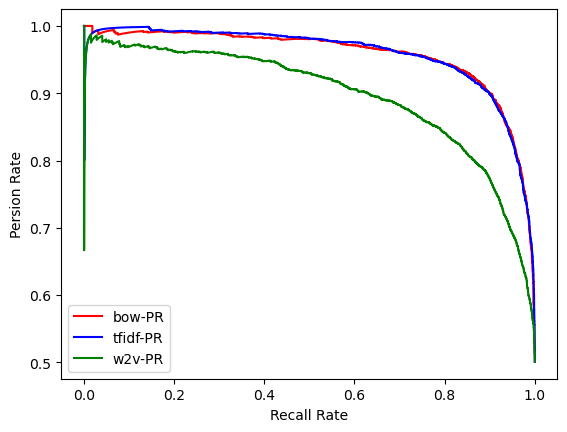

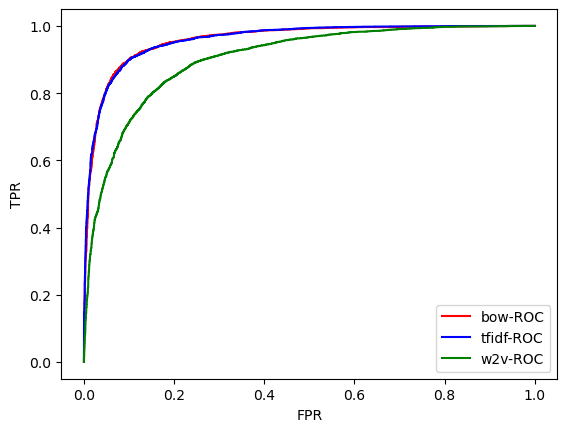

In [17]:
report(lr_bow_predict,lr_tfidf_predict,lr_w2v_predict)
plot_roc(lr_bow_predict,lr_tfidf_predict,lr_w2v_predict,lr_bow,lr_tfidf,lr_w2v)

**Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features**

In [18]:
#training the linear svm
bowSvm=SGDClassifier(loss = "log")
tfidfSvm=SGDClassifier(loss = "log")
w2vSvm=SGDClassifier(loss = "log")
#fitting the svm 
svm_bow=bowSvm.fit(cv_train_reviews,train_sentiments)
svm_tfidf=tfidfSvm.fit(tv_train_reviews,train_sentiments)
svm_w2v=w2vSvm.fit(trainDataVecs,train_sentiments)

**Model performance on test data**

In [19]:
#Predicting the model
svm_bow_predict=bowSvm.predict(cv_test_reviews)
print(svm_bow_predict)
svm_tfidf_predict=tfidfSvm.predict(tv_test_reviews)
print(svm_tfidf_predict)
svm_w2v_predict=w2vSvm.predict(testDataVecs)
print(svm_w2v_predict)

[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


**Accuracy of the model**

              precision    recall  f1-score   support

    Positive       0.89      0.90      0.90      4993
    Negative       0.90      0.89      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

              precision    recall  f1-score   support

    Positive       0.89      0.87      0.88      4993
    Negative       0.87      0.89      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

    Positive       0.80      0.85      0.83      4993
    Negative       0.84      0.78      0.81      5007

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

[[4465  542]
 [ 487

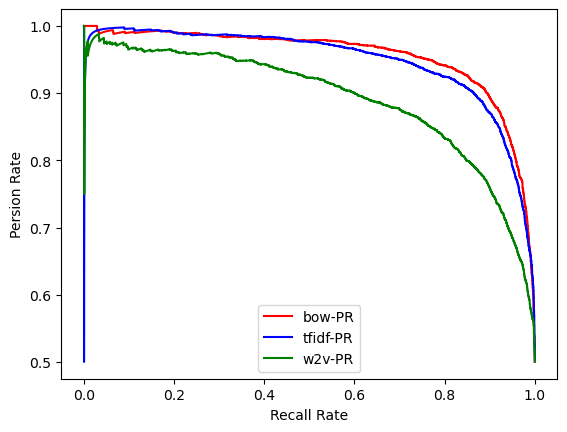

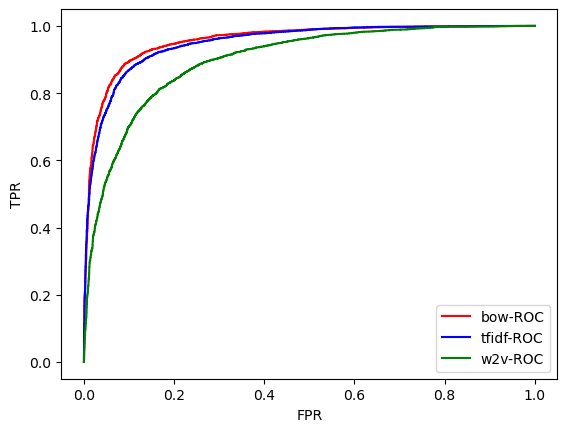

In [20]:
report(svm_bow_predict,svm_tfidf_predict,svm_w2v_predict)
plot_roc(svm_bow_predict,svm_tfidf_predict,svm_w2v_predict,svm_bow,svm_tfidf,svm_w2v)

**Decision tree**

In [16]:
from sklearn.tree import DecisionTreeClassifier

bowdt = DecisionTreeClassifier()
tfidfdt = DecisionTreeClassifier()
w2vdt = DecisionTreeClassifier()

dt_bow=bowdt.fit(cv_train_reviews, train_sentiments)
dt_tfidf=tfidfdt.fit(tv_train_revi ews, train_sentiments)
dt_w2v=w2vdt.fit(trainDataVecs, train_sentiments)

**test predict**

In [18]:
dt_bow_predict=dt_bow.predict(cv_test_reviews)
dt_tfidf_predict=dt_tfidf.predict(tv_test_reviews)
dt_w2v_predict=dt_w2v.predict(testDataVecs)

**performance on test data**

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      4993
    Negative       0.74      0.74      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    Positive       0.72      0.73      0.72      4993
    Negative       0.73      0.72      0.72      5007

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

              precision    recall  f1-score   support

    Positive       0.72      0.71      0.71      4993
    Negative       0.71      0.72      0.72      5007

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

[[3707 1300]
 [1317

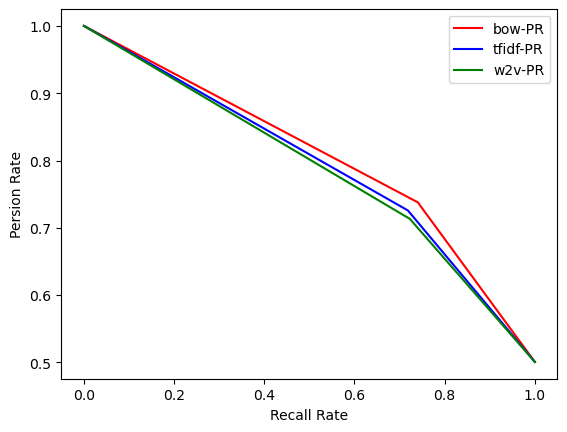

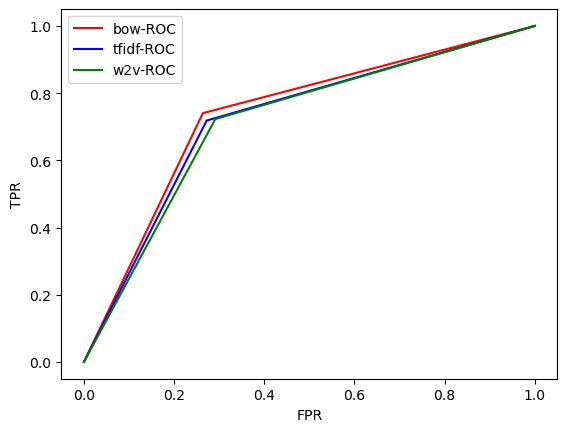

In [23]:
report(dt_bow_predict,dt_tfidf_predict,dt_w2v_predict)
plot_roc(dt_bow_predict,dt_tfidf_predict,dt_w2v_predict,dt_bow,dt_tfidf,dt_w2v)

**LSTM**

In [24]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index
# print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

#create sequences of reviews
seq_train = tokenizer.texts_to_sequences(norm_train_reviews[:20000])
seq_test =  tokenizer.texts_to_sequences(norm_test_reviews)

#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,train_sentiments[:20000],
                                             test_size=0.2,random_state=10)

D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

Vocabulary of the dataset is :  112174
Maximum length of sequence in the list: 1136
Maximum length of the sequence when considering data only two standard deviations from average: 319
The above calculated number coveres approximately 94.57 % of data
----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 319)]             0         
                                                                 
 embedding (Embedding)       (None, 319, 64)           7179200   
                                                                 
 batch_normalization (BatchN  (None, 319, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 319, 64)           0         
                                                

**LSTM-evaluate**

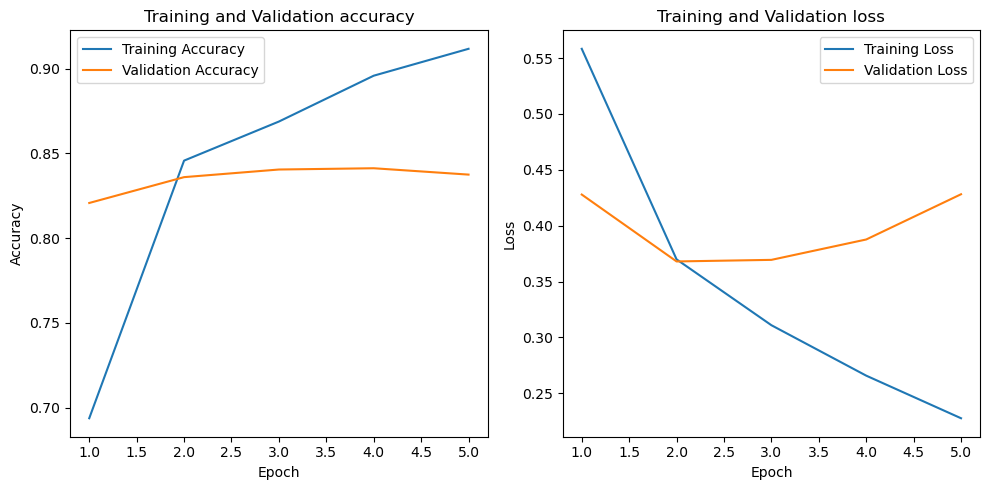

Evaluate Model Performance on Test set
313/313 [==============================] - 5s 12ms/step - loss: 0.4401 - accuracy: 0.8338
{'loss': 0.4401136636734009, 'accuracy': 0.8338000178337097}
313/313 [==============================] - 4s 10ms/step


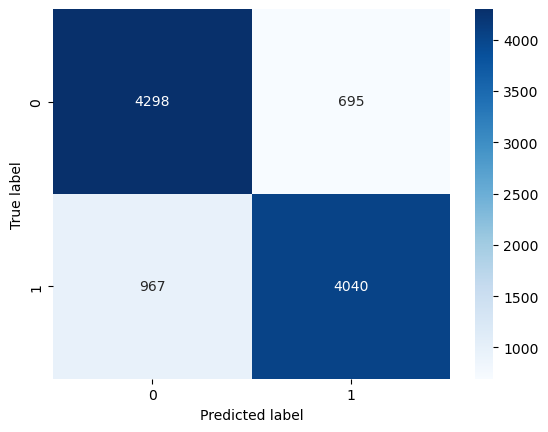

In [27]:
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

def plotLearningCurve(history,epochs):
    epochRange = range(1,epochs+1)
    fig , ax = plt.subplots(1,2,figsize = (10,5))

    ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
    ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    fig.tight_layout()
    plt.show()

#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,test_sentiments)
print(dict(zip(model.metrics_names, result)))

#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(test_sentiments, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

**LSTM-ROC**

precision_score  recall_score  f1_score
LSTM: 0.853     0.807     0.829


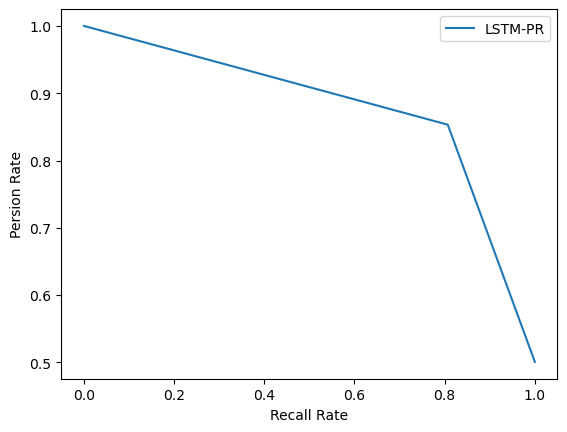

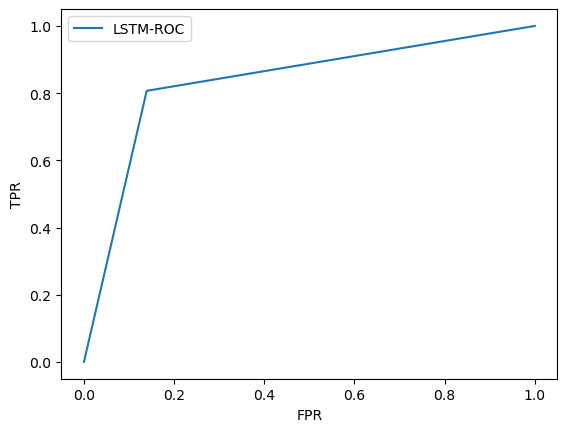

In [28]:
from sklearn.metrics import precision_recall_fscore_support
#1） F1,P,R
P1=precision_score(test_sentiments,ypred,average='binary')
R1=recall_score(test_sentiments,ypred,average='binary')
F1_1=f1_score(test_sentiments,ypred,average='binary')
print("precision_score  recall_score  f1_score")
print('LSTM: %.3f'%P1,'    %.3f'%R1,'    %.3f'%F1_1)

#2） P-R曲线,ROC曲线
precision,recall,_=precision_recall_curve(test_sentiments,ypred)
fpr,tpr,_=roc_curve(test_sentiments,ypred)

#1. P-R曲线 
plt.plot(recall,precision,label='LSTM-PR')
plt.xlabel('Recall Rate')
plt.ylabel('Persion Rate')
plt.legend()
plt.show()

#2. ROC曲线
plt.plot(fpr,tpr,label='LSTM-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()